# Important Note:
### The thinning algorithm is a stochastic process. So different runs of this testing code can give slightly different results.

In [ ]:
import sys
sys.path.append("../")

In [ ]:
import numpy as np
import torch as pt
from tqdm import tqdm

# Thinning algorithm for time prediction
Note : Here we are interested to see if given a known history of times and events, the neural network can predict the next time and event type or not. So, to test the $(i+1)^{th}$ arrival time and event, we will use the actual history (event type and time) of the sequence upto the $i^{th}$ step.

In [ ]:
# For now, we'll test the data one sequence at a time
def getSeqData(net, seq, seqLabels, LenSeq, times):
    
    # net : trained network
    # seq : one-hot encoded sequence
    # seqLabels : labels of outcomes at each time stamp
    # times : times of each event in the sequence
    
    N_events = LenSeq
    N_event_types = seq.shape[1]
    mask = seqLabels.ge(-1+0.0001)
    
    # Send the sequence through the network
    lambOuts, CLows, Cbars, deltas, OutGates = net.forward(seq.view(-1, N_events, N_event_types),
                                                           mask.view(-1, N_events), times.view(-1, N_events+1))
    
    # Arrays to store predicted times and events
    events_predicted = pt.zeros(N_events, dtype=int)
    times_predicted = pt.zeros(N_events)
    
    # Array to store event prediction accuracy
    corrects = pt.zeros(N_events, dtype=int) # 0 means wrong, 1 means correct
    
    for i in range(N_events): #tqdm(, position=0, leave=True):
        
        # First, let's work on computing the supremum rate
        
        # We need the LSTM parameters at this time index
        cL = CLows[:, i]
        cB = Cbars[:, i]
        o = OutGates[:, i]
        delta = deltas[:, i]
        tLow = times[i].item()
        
        # With cL and cB, we compute hL and hB
        hL = o * (2*net.sigma(2*cL) - 1)
        hB = o * (2*net.sigma(2*cB) - 1)
        
        # Once hMax is computed, we need to compute the lambda_til
        lamb_til_L = net.L_lamb_til(hL)
        lamb_til_B = net.L_lamb_til(hB)
        
        # Next, we have to select the maximum
        lamb_til_max = pt.max(lamb_til_L, lamb_til_B)
        
        # Then, we calculate lambda_max
        lambda_max = net.scale * pt.log(1 + pt.exp(lamb_til_max/net.scale)).view(N_event_types)
        # so, lambda_max[k] contains the supremum rate of event type k
        
        lamb_max_total = pt.sum(lambda_max).item()
        # print(lamb_max_total)
        # Next, we draw some random times and keep testing for arrival
        t = tLow
        cond = True
        while cond:
            # draw random increment
            Del = -np.log(np.random.rand())/lamb_max_total
            t += Del
            ct = cB + (cL - cB)*pt.exp(-(t - tLow)*delta)
            ht = o * (2*net.sigma(2*ct) - 1)
            lamb_til = net.L_lamb_til(ht)
            lamb = net.scale * pt.log(1 + pt.exp(lamb_til/net.scale)).view(N_event_types)
            lamb_total = pt.sum(lamb).item()
            
            # Next, acceptance test
            if lamb_total/lamb_max_total > np.random.rand():
                # then we accept
                cond=False
                
                # once accepted we have to disaggregate to get the next event
                # First, convert the intensities into relative probabilites
                lamb_prob = lamb/lamb_total
                
                # Then convert this into cumulative probabilities
                # print(lamb_prob)
                lamb_csum = pt.cumsum(lamb_prob, dim=0)
                
                # relative probs example : [0.1, 0.5, 0.4]
                # cumulative : [0.1, 0.6, 1.0]
                
                # Then draw a random number in (0,1)
                rn = np.random.rand()
                
                # Find which event this corresponds to
                ev = pt.searchsorted(lamb_csum, rn).item()
                
                # store this
                events_predicted[i] = ev
                times_predicted[i] = t
                if ev == seqLabels[i].item():
                    corrects[i] = 1
    
    return times_predicted, events_predicted, corrects

# Load the network upto 28 epochs of training

In [ ]:
net = pt.load("SO_Nets/TrainNet_SO_28ep.pt")

# Load the testing data from HDF5 file

In [ ]:
import h5py
with h5py.File("SOTestData.h5", "r") as fl:
    EventsData = np.array(fl["EventsData"])
    timesData = np.array(fl["TimesData"])
    timeMaxData = np.array(fl["TimeMaxData"])
    SeqLengthData = np.array(fl["SeqLengthData"])

In [ ]:
# Make one-hot encoded events
# Make the events one hot encoded
N_test = EventsData.shape[0]
N_seq_Max = EventsData.shape[1]
N_types = 22
Events_one_hot = np.zeros((N_test, N_seq_Max, N_types))
for seq in range(N_test):
    for step in range(SeqLengthData[seq]):
        ev = EventsData[seq, step]
        Events_one_hot[seq, step, ev] = 1.0

In [ ]:
# Then convert everything to torch tensors
# Since maximum times are very large here,
# we scale them down so that gradients don't explode
# This doesn't affect final results, since we can always
# scale testing times by the same amount too
timeScale = 1.0
EvTens = pt.tensor(Events_one_hot).double()
EvIndTens = pt.tensor(EventsData).long()
timeTensor = pt.tensor(timesData/timeScale).double()
tMaxTensor = pt.tensor(timeMaxData/timeScale).double()

## Let's first test a randomly chosen sample

In [ ]:
Idx = 2
LenSeq = SeqLengthData[Idx]
seq, seqLabels, times = EvTens[Idx, :LenSeq], EvIndTens[Idx, :LenSeq],  timeTensor[Idx, :LenSeq+1]

In [ ]:
times_predicted, events_predicted, corrects = getSeqData(net, seq, seqLabels, LenSeq, times)

In [ ]:
pt.sum(corrects)/len(corrects)

tensor(0.9412)

## Now let's test all the testing sequences
Note: The thinning algorithm is stochastic, so sometimes it might take a while to predict the next arrival time.

In [ ]:
times_Test = pt.ones(N_test, N_seq_Max)*-1  # negative time means no event occurred
correctFrac = pt.zeros(N_test)
# perm = pt.randperm(N_test) # select random test samples
for Idx in tqdm(range(N_test), position=0, leave=True):
    LenSeq = SeqLengthData[Idx]
    
    seq, seqLabels, times = EvTens[Idx, :LenSeq], EvIndTens[Idx, :LenSeq],\
    timeTensor[Idx, :LenSeq+1]
    
    times_predicted, events_predicted, corrects = getSeqData(net, seq, seqLabels, LenSeq, times)
    
    correctFrac[Idx] = pt.sum(corrects)/len(corrects)
    
    times_Test[Idx, :LenSeq] = times_predicted

100%|██████████| 1326/1326 [06:06<00:00,  3.62it/s] 


In [ ]:
correctFrac = correctFrac.numpy()
times_Test = times_Test.numpy()

In [ ]:
print("Mean next event type prediction accuracy: {:.4f}%".format(np.mean(correctFrac)*100))

Mean next event type prediction accuracy: 98.2660%


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Let's plot a few time evolutions and predicted next arrival time
# Based on known history
# Since the first step has no history to infer from,
# We check from the second step onward
Idx1 = 100
Idx2 = 250
TimesActual1 = timesData[Idx1, 2:]
TimesPredicted1 = times_Test[Idx1,1:]
LenSeq1 = SeqLengthData[Idx1]

TimesActual2 = timesData[Idx2, 2:]
TimesPredicted2 = times_Test[Idx2, 1:]
LenSeq2 = SeqLengthData[Idx2]

Text(0.5, 0, 'Time Step')

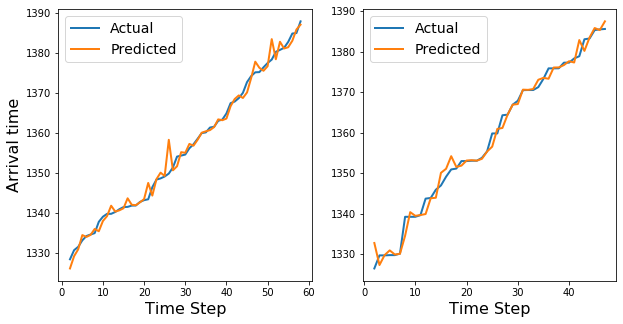

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(2, LenSeq1+1, 1), TimesActual1[:LenSeq1-1], lw=2, label="Actual")
plt.plot(np.arange(2, LenSeq1+1, 1), TimesPredicted1[:LenSeq1-1], lw=2, label="Predicted")
plt.legend(fontsize=14)
plt.ylabel("Arrival time", fontsize=16)
plt.xlabel("Time Step", fontsize=16)
plt.subplot(1,2,2)
plt.plot(np.arange(2, LenSeq2+1, 1), TimesActual2[:LenSeq2-1], lw=2, label="Actual")
plt.plot(np.arange(2, LenSeq2+1, 1), TimesPredicted2[:LenSeq2-1], lw=2, label="Predicted")
plt.legend(fontsize=14)
plt.xlabel("Time Step", fontsize=16)

# Next, let's compute the RMSE

In [ ]:
SeqAvgs = np.zeros(N_test)
SeqLogAvgs = np.zeros(N_test)
for seq in range(N_test):
    LenSeq = SeqLengthData[seq]
    # In the actual times, the 0^th time is stored as 0
    # The 1^st time has no history before it,
    # So we test the 2^nd time step onward,
    timeActual = timesData[seq, 2:LenSeq+1]
    timePredicted = times_Test[seq, 1:LenSeq]
    
    dT2 = (timePredicted - timeActual)**2
    dT2_avg = np.sum(dT2)/LenSeq
    SeqAvgs[seq] = dT2_avg

In [ ]:
# First, let's get rid of outliers
# We define outliers as those which have MSE of predicted time > 1e4
SeqAvgs_non_outlier = []
count = 0
for i in range(N_test):
    if SeqAvgs[i] > 10000:
        count += 1
    else:
        SeqAvgs_non_outlier.append(SeqAvgs[i])

In [ ]:
print("Percentage of samples with MSE > 10000 (Outliers): {:.4f}%".format(count*100/N_test))

Percentage of samples with MSE > 10000 (Outliers): 1.5083%


In [ ]:
print("Average Root Mean squared error across " 
      "{} Non-outlier test sequences: {}".format(len(SeqAvgs_non_outlier),
                                                 np.sqrt(np.mean(SeqAvgs_non_outlier))))

Average Root Mean squared error across 1306 Non-outlier test sequences: 2.976643008071267
